# 1.  Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
import unidecode
import contractions
import emoji

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud

from textatistic import Textatistic
import spacy

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from sklearn.naive_bayes import MultinomialNB



# 2. Loading Data

In [2]:
data = pd.read_csv('train.csv')

# 3. Text Cleaning and Feature Extraction

## 3.1 Disaster vs. Non Disaster

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


          id  keyword  location  text
target                               
0       4342     4323      2884  4342
1       3271     3229      2196  3271


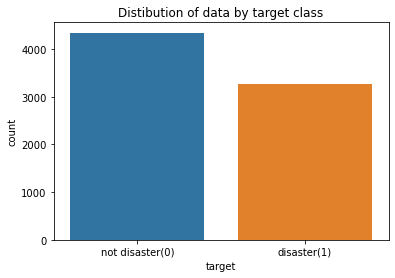

In [4]:
target_distribution = sns.countplot(x='target', data = data)
target_distribution.set_xticklabels(['not disaster(0)', 'disaster(1)'], rotation=0)
plt.title('Distibution of data by target class');
print(data.groupby('target').count())

##### Target: Not a disaster = 0 and disaster = 1

### 3.2 Id
Note that the id values aren't in chronological order, so they aren't useful so we can just drop this column. 

In [5]:
#dropping ID values
data = data.drop('id', axis = 1)

In [6]:
data.shape

(7613, 4)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 238.0+ KB


In [8]:
data.describe()

,target
count,7613.00000
mean,0.42966
std,0.49506
min,0.00000
25%,0.00000
50%,0.00000
75%,1.00000
max,1.00000


Not very insightful, so let's instead have a look at the data when we group it by the two different target classes. 

### 3.3 Duplicates

In [9]:
data.groupby('target').describe()

keyword                          location                        text  \
         count unique          top freq    count unique       top freq count   
target                                                                         
0         4323    218  body%20bags   40     2884   2142  New York   55  4342   
1         3229    220   derailment   39     2196   1513       USA   67  3271   

                                                                       
       unique                                                top freq  
target                                                                 
0        4315  The Prophet (peace be upon him) said 'Save you...    4  
1        3206  11-Year-Old Boy Charged With Manslaughter of T...   10

##### Possible duplicates?

In [10]:
pd.options.display.max_colwidth = 190
data[data['text'].str.contains('Save yourself from Hellfire even ')]

,keyword,location,text,target
4284,hellfire,NaN,The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',0
4286,hellfire,Riyadh,The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',0
4292,hellfire,NaN,The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',1
4304,hellfire,NaN,The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',0
4309,hellfire,NaN,The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',0
4318,hellfire,NaN,The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',1


Whilst the tweets are the same, we can see these are all associated with keywords and have different ids and also varies in the target classes. So, we are not going to omit these. 

In [11]:
pd.options.display.max_colwidth = 190
data[data['text'].str.contains('11-Year-Old Boy Charged With')]

,keyword,location,text,target
3578,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1
3589,fatal,Varanasi,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1
3591,fatal,Thane,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1
3597,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1
3600,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1
3603,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1
3604,fatal,Bangalore,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1
3610,fatal,Dimapur,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1
3613,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1
3614,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1


# Question: Should we drop all but one of these?
We can see these all are different tweets reporting the same event.

### 3.4 Missing Data

In [12]:
(data.isna().sum()/len(data))*100

keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

Over 33% of the location data is missing, so this could potentially be dropped. An advantage is there are no missing data for text nor target values. Furthermore, less than 1% of the data is missing for keyword. Let's first get a better picture of the distribution of missing data, and then explore how to we should process the text and keyword data. 

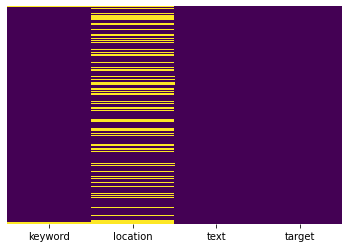

In [13]:
missing_data = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

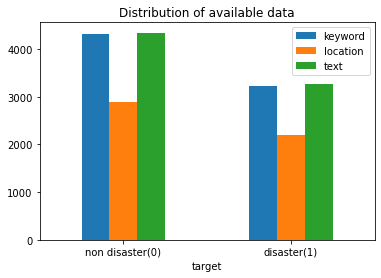

In [14]:
ax = data.groupby('target').count().plot(kind='bar', 
                                       title='Distribution of Data', 
                                      legend=True)
ax.set_xticklabels(['non disaster(0)', 'disaster(1)'], rotation=0)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Distribution of available data');

Roughly the same proportion of data is missing from the disaster class as non disterous classes. This could mean we may not find any meaningful insights from identifying what data is missing. Let's see if we can break down the keywords and location data further. 

In [15]:
data.groupby('target').count()

,keyword,location,text
target,,,
0,4323,2884,4342
1,3229,2196,3271


We can see that the dataset is unevenly distributed, favouring tweets not associated with disasters more than those of disasters. 

### 3.5 Keywords

Can we drop keywords column are are there patterns for missing or not missing values? 

#### 3.5.1 

Let's have a closer look at keywords to see if there are any noticeable characteristics based on the two different target classes. 

In [16]:
keywords = data.drop(['location', 'text'], axis = 1)
keywords_disaster = keywords[keywords['target']==1]
keywords_nondisaster = keywords[keywords['target']==0]

In [17]:
(keywords_disaster.isnull().sum()/len(keywords_disaster))*100

keyword    1.284011
target     0.000000
dtype: float64

In [18]:
(keywords_nondisaster.isnull().sum()/len(keywords_nondisaster))*100

keyword    0.437586
target     0.000000
dtype: float64

We don't really see a pattern with which tweets have keywords or which don't based on the target values. Whilst disaster tweets have 1.28% of their keywords missing and non disaster tweets have 0.45% of the keywords missing, I think it'll be misleading to focus on how disaster tweets have more than twice the number of missing keywords 1.28% is still relatively small. Instead, let's have a look at keywords themselves to see if there are common keywords between the two target classes. 

In [19]:
keywords = keywords.dropna()
print(keywords.nunique())
print(len(keywords))

keyword    221
target       2
dtype: int64
7552


There are 221 unique keywords out of 7552. 

#### 3.5.2 Keywords - EDA
Let's try and create a wordcloud to visaulise the different vocabulary used in the two different classes, and explore which terms they have in common

In [20]:
#lets clean the keywords so it omits %20, any accents and punctuation
def clean_keywords(keyword):
    cleaned = re.sub(r'%20', '', keyword)
    return cleaned
def remove_accents(keyword):
    cleaned = unidecode.unidecode(keyword)
    return cleaned
def remove_punctuation(keyword):
    cleaned = re.sub(r'[^\w\s\d]','',keyword)
    return cleaned
keywords['keyword'] = keywords['keyword'].apply(lambda x: clean_keywords(x))
keywords['keyword'] = keywords['keyword'].apply(lambda x: remove_accents(x))
keywords['keyword'] = keywords['keyword'].apply(lambda x: remove_punctuation(x))

In [21]:
keywords['target_mean'] = keywords.groupby('keyword')['target'].transform('mean')

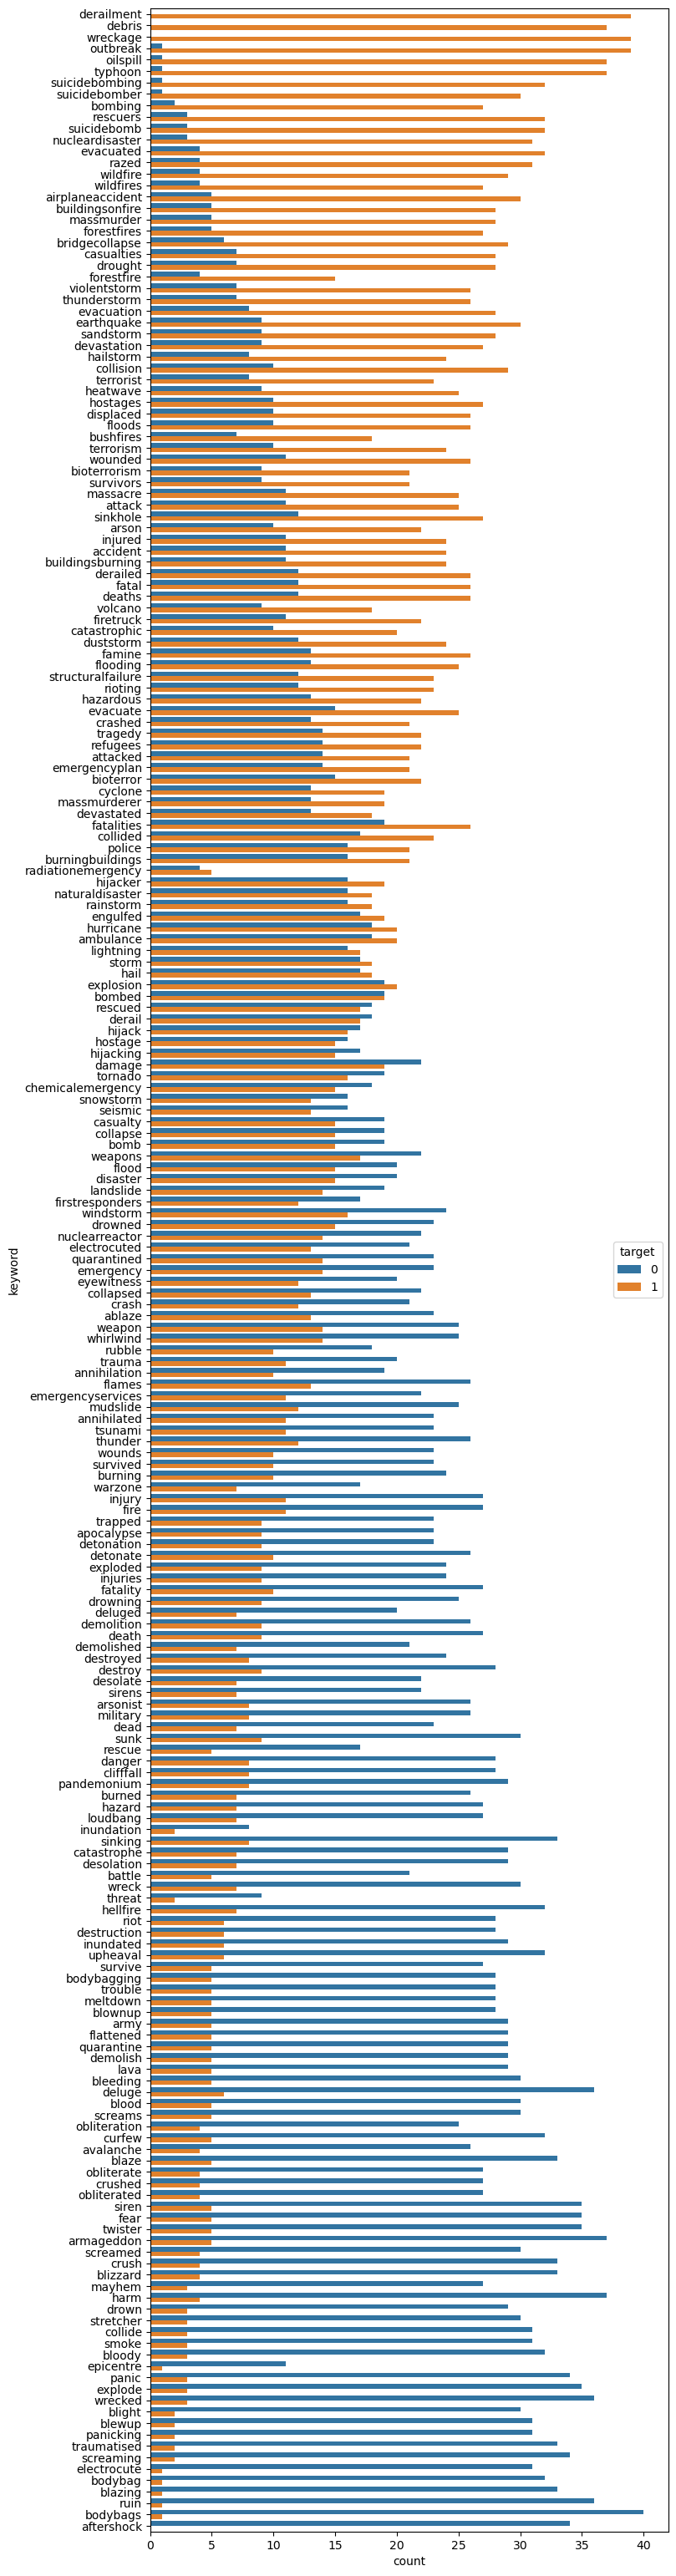

In [22]:
fig = plt.figure(figsize=(8, 40), dpi=100)
sns.countplot(y=keywords.sort_values(by='target_mean', ascending = False)['keyword'], 
              hue = keywords.sort_values(by='target_mean', ascending =False)['target'])
plt.show()

In [23]:
def make_dict(tup, dictionary):
    for x, y in tup:
        dictionary.setdefault(x, []). append(y)
    return dictionary

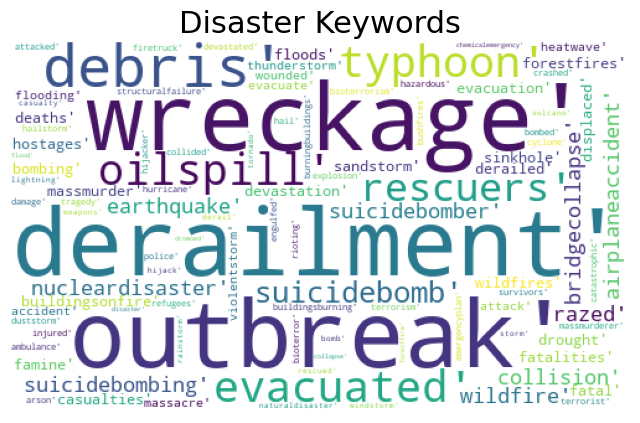

In [24]:
count = Counter(list(keywords[keywords['target']==1]['keyword']))
top_words = {}
make_dict(count.most_common(100), top_words)
df = pd.DataFrame.from_dict(top_words, orient = 'index').reset_index()
df.columns=['word', 'count']
text = df['word'].values
wordcloud_keywords = WordCloud(background_color = 'white', width = 500, height = 300, collocations = True).generate(str(text))
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(wordcloud_keywords)
plt.axis('off')
plt.title('Disaster Keywords', fontsize = 22)
plt.show()

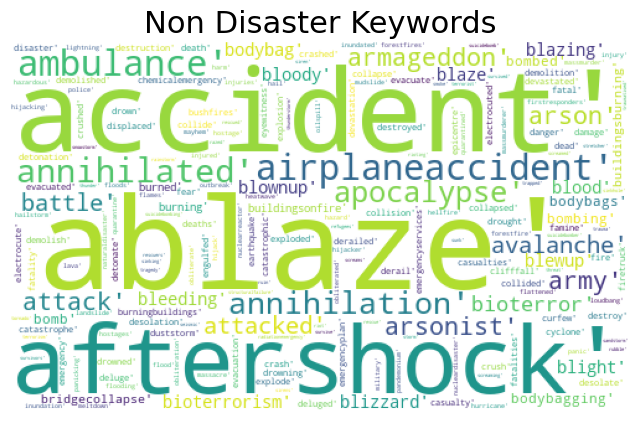

In [25]:
count = Counter(list(keywords[keywords['target']==0]['keyword']))
top_words = {}
make_dict(count.most_common(100), top_words)
df = pd.DataFrame.from_dict(top_words, orient = 'index').reset_index()
df = pd.DataFrame.from_dict(count, orient = 'index').reset_index()
df.columns=['word', 'count']
text = df['word'].values
wordcloud_keywords = WordCloud(background_color = 'white', width = 500, height = 300, collocations = True).generate(str(text))
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(wordcloud_keywords)
plt.axis('off')
plt.title('Non Disaster Keywords', fontsize = 22)
plt.show()

#### 3.5.3 Conclusion
We do see some commonalities in the choice of keywords but we also see there are keywords that appear more frequently in one class compared to others: body bags for example appears a lot more frequently as a keyword for non disasterous tweets than disasterous tweets. There are three words, delairment, debris, and wreckage, which only appear as keywords for disaster tweets whilst aftershock only appears as a kew word in non disaster tweets. From this we can conclude that there aren't sufficent difference in the keywords to try and develop a classification model. As a result we will drop this for future analysis. 

### 3.6 Location

In [26]:
location_disaster = data[data['target']==1].drop(['text','keyword'], axis = 1)
location_nondisaster = data[data['target']==0].drop(['text','keyword'], axis = 1)
print((location_disaster.isnull().sum()/len(location_disaster))*100)
print((location_nondisaster.isnull().sum()/len(location_nondisaster))*100)

location    32.864567
target       0.000000
dtype: float64
location    33.578996
target       0.000000
dtype: float64


Disaster and Non Disaster tweets seem to have the same proportion of missing data: roughly 34 percent. This is quite a large portion so this might not be a great feature to use for our classification model. 

In [27]:
location = data[data['location'].notnull()].drop(['text', 'keyword'], axis = 1)
location.head()

,location,target
31,Birmingham,1
32,Est. September 2012 - Bristol,0
33,AFRICA,1
34,"Philadelphia, PA",0
35,"London, UK",0


In [28]:
location['target'].value_counts()

0    2884
1    2196
Name: target, dtype: int64

In [29]:
print(location['location'].nunique())
print(len(location))

3341
5080


In [30]:
#lets remove dates, punctuation, and make all the text lowercase
def remove_accents(keyword):
    cleaned = unidecode.unidecode(keyword)
    return cleaned
def remove_punctuation(keyword):
    cleaned = re.sub(r'[^\w\s\d]','',keyword)
    return cleaned
def lower_case(keyword):
    lower_case = keyword.lower()
    return lower_case
#remove numerical values 
def remove_nums(keyword):
    cleaned = re.sub(r'\d+', '', keyword)
    return cleaned
location['location'] = location['location'].apply(lambda x: remove_accents(x))
location['location'] = location['location'].apply(lambda x: remove_punctuation(x))
location['location'] = location['location'].apply(lambda x: lower_case(x))
location['location'] = location['location'].apply(lambda x: remove_nums(x))

#### 3.6.2 Location EDA
We have too many unique values here compared to keywords so let's have a look at the wordcloud for location based on their target classes. 

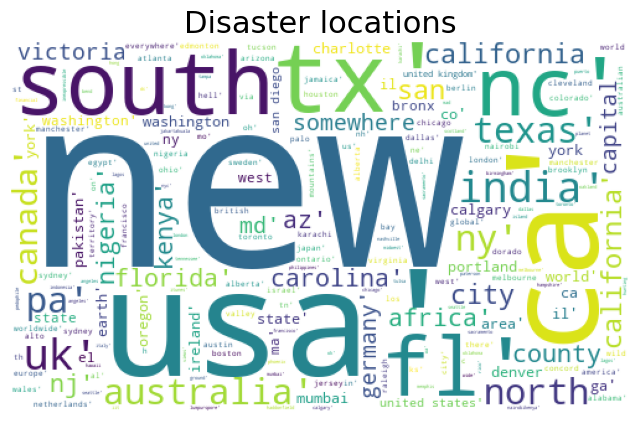

In [31]:
count = Counter(list(location[location['target']==1]['location']))
top_words = {}
make_dict(count.most_common(500), top_words)
df = pd.DataFrame.from_dict(top_words, orient = 'index').reset_index()
df.columns=['word', 'count']
text = df['word'].values
wordcloud_keywords = WordCloud(background_color = 'white', width = 500, height = 300, collocations = True).generate(str(text))
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(wordcloud_keywords)
plt.axis('off')
plt.title('Disaster locations', fontsize = 22)
plt.show()

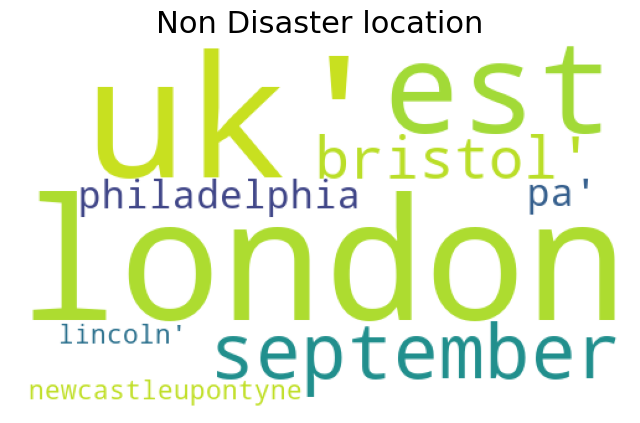

In [32]:
count = Counter(list(location[location['target']==0]['location']))
top_words = {}
make_dict(count.most_common(500), top_words)
df = pd.DataFrame.from_dict(top_words, orient = 'index').reset_index()
df = pd.DataFrame.from_dict(count, orient = 'index').reset_index()
df.columns=['word', 'count']
text = df['word'].values
wordcloud_keywords = WordCloud(background_color = 'white', width = 500, height = 300, collocations = True).generate(str(text))
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(wordcloud_keywords)
plt.axis('off')
plt.title('Non Disaster location', fontsize = 22)
plt.show()

#### 3.6.3 Conclusion
We will drop location as a feature going forwards

### 3.7 Tweets EDA
Basic features: number of words, average length of words, number of hashtags, number of characters; named entitdf.y recognition

In [33]:
tweets = data.drop(['keyword', 'location'], axis = 1)

#### 3.7.1 Feature Extraction
Let's look at a few features first to see if we can get an insight into popssible features that could be of interest for the tweets prior to pre processing. 

In [34]:
#number of charecters (including white space) in each tweet
tweets['num_chars'] = tweets['text'].apply(len)
#number of words 
def word_count(string):
    words = string.split()
    return len(words)
tweets['num_words'] = tweets['text'].apply(word_count)
# average word length
def mean_word_length(x):
    words = x.split() #split the sentences into words
    word_len = [len(word) for word in words] #count the length of each word in the sentence
    mean_word_length = sum(word_len)/len(words)
    return(mean_word_length)
tweets['mean_word_length'] = tweets['text'].apply(mean_word_length)
def hash_count(string):
    words = string.split()
    hashtags = [word for word in words if word.startswith('#')]
    return len(hashtags)
tweets['num_hashtags'] = tweets['text'].apply(hash_count)
def mention_count(string):
    words = string.split()
    mentions = [word for word in words if word.startswith('@')]
    return len(mentions)
tweets['mentions'] = tweets['text'].apply(mention_count)
def emoji_count(tweet):
    tweet = emoji.demojize(tweet, delimiters=('__','__'))
    pattern = r'_+[a-z_&]+_+'
    return len(re.findall(pattern, tweet))
tweets['emojis'] = tweets['text'].apply(emoji_count)

In [35]:
#let's explore the difference in the tweets for disaster and non disasters. 
disaster_tweets = tweets[tweets['target']==1]
nondisaster_tweets = tweets[tweets['target']==0]
tweets.head()

,text,target,num_chars,num_words,mean_word_length,num_hashtags,mentions,emojis
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,13,4.384615,1,0,0
1,Forest fire near La Ronge Sask. Canada,1,38,7,4.571429,0,0,0
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133,22,5.090909,0,0,0
3,"13,000 people receive #wildfires evacuation orders in California",1,65,8,7.125000,1,0,0
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,16,4.500000,2,0,0


#### 3.7.1. Number of Characters 

In [36]:
print('Summary of Number of Characters in Disaster Tweets:')
print(disaster_tweets.num_chars.describe())
print('\n')
print('Summary of Number of Characters in Non Disaster Tweets:')
print(nondisaster_tweets.num_chars.describe())

Summary of Number of Characters in Disaster Tweets:
count    3271.000000
mean      108.113421
std        29.309854
min        14.000000
25%        88.000000
50%       115.000000
75%       136.000000
max       151.000000
Name: num_chars, dtype: float64


Summary of Number of Characters in Non Disaster Tweets:
count    4342.000000
mean       95.706817
std        35.885924
min         7.000000
25%        68.000000
50%       101.000000
75%       130.000000
max       157.000000
Name: num_chars, dtype: float64


In [37]:
nondisaster_tweets[nondisaster_tweets['num_chars']==157]

,text,target,num_chars,num_words,mean_word_length,num_hashtags,mentions,emojis
1270,when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????,0,157,21,6.52381,0,0,0


In [38]:
nondisaster_tweets[nondisaster_tweets['num_chars']==7]

,text,target,num_chars,num_words,mean_word_length,num_hashtags,mentions,emojis
1882,Crushed,0,7,1,7.0,0,0,0
4890,Bad day,0,7,2,3.0,0,0,0
5115,Err:509,0,7,1,7.0,0,0,0


In [39]:
disaster_tweets[disaster_tweets['num_chars']==151]

,text,target,num_chars,num_words,mean_word_length,num_hashtags,mentions,emojis
614,@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?@VP,1,151,22,5.909091,0,2,0


In [40]:
disaster_tweets[disaster_tweets['num_chars']==14]

,text,target,num_chars,num_words,mean_word_length,num_hashtags,mentions,emojis
7589,Omg earthquake,1,14,2,6.5,0,0,0


In [41]:
# We already have a function from when we were cleaning keywords which we can reuse on the tweets. 
processed_tweets = pd.DataFrame()
processed_tweets['target'] = tweets['target']
processed_tweets['text'] = tweets['text']

When we look at the longest tweets for disasters and non-disasters they both have a lot of punctuation. This might be worth removing. When we look at the shorter tweets, it's quite clear that we might benefit from expanding on common contractions in colloquial English.

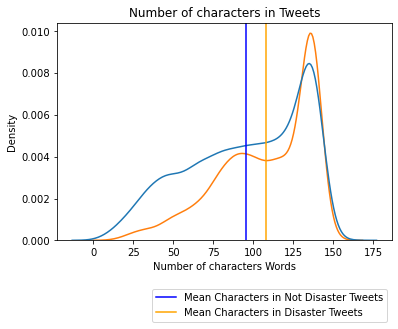

In [42]:
_ = sns.kdeplot(x='num_chars', hue='target', data = tweets)
_ = plt.axvline(x=tweets[tweets['target']==0]['num_chars'].mean(), color='blue', label='Mean Characters in Not Disaster Tweets')
_ = plt.axvline(x=tweets[tweets['target']==1]['num_chars'].mean(), color = 'orange', label='Mean Characters in Disaster Tweets')
_ = plt.title('Number of characters in Tweets')
_ = plt.xlabel('Number of characters Words')
_ = plt.legend(bbox_to_anchor = (1,-0.2))
_ = plt.show()

#### 3.7.2 Number of words in tweets
When looking at the number of characters in tweets, we saw that some of the tweets were one-two words long and one of these instances included and error message. I think it's a good idea to limit the number of words to 2 or more for each tweet but before doing so let's explore the number of words in tweets in the two different classes. 

In [43]:
#let's explore the difference in the tweets for disaster and non disasters. 
print('Summary of Number of Words in Disaster Tweets:')
print(disaster_tweets.num_words.describe())
print('\n')
print('Summary of Number of Words in Non Disaster Tweets:')
print(nondisaster_tweets.num_words.describe())

Summary of Number of Words in Disaster Tweets:
count    3271.000000
mean       15.167533
std         5.096806
min         2.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        30.000000
Name: num_words, dtype: float64


Summary of Number of Words in Non Disaster Tweets:
count    4342.000000
mean       14.704744
std         6.161564
min         1.000000
25%        10.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: num_words, dtype: float64


In [44]:
tweets[tweets['num_words']==1]

,text,target,num_chars,num_words,mean_word_length,num_hashtags,mentions,emojis
24,LOOOOOOL,0,8,1,8.0,0,0,0
1882,Crushed,0,7,1,7.0,0,0,0
3667,Fatality!,0,9,1,9.0,0,0,0
3670,fatality,0,8,1,8.0,0,0,0
4971,Meltdown,0,8,1,8.0,0,0,0
5115,Err:509,0,7,1,7.0,0,0,0
5184,Obliterated,0,11,1,11.0,0,0,0
6705,Thunder???,0,10,1,10.0,0,0,0


In [45]:
tweets[tweets['num_words']==2]

,text,target,num_chars,num_words,mean_word_length,num_hashtags,mentions,emojis
22,Love skiing,0,11,2,5.0,0,0,0
28,Cooool :),0,9,2,4.0,0,0,0
30,The end!,0,8,2,3.5,0,0,0
113,Aftershock https://t.co/xMWODFMtUI,0,34,2,16.5,0,0,0
131,Aftershock https://t.co/jV8ppKhJY7,0,34,2,16.5,0,0,0
276,Apocalypse please,0,17,2,8.0,0,0,0
321,Armageddon https://t.co/uCSUDk3q1d,1,34,2,16.5,0,0,0
323,@paddytomlinson1 ARMAGEDDON,0,27,2,13.0,0,1,0
433,@local_arsonist LMFAO,0,21,2,10.0,0,1,0
783,@kynespeace *blight,0,19,2,9.0,0,1,0


# comment 

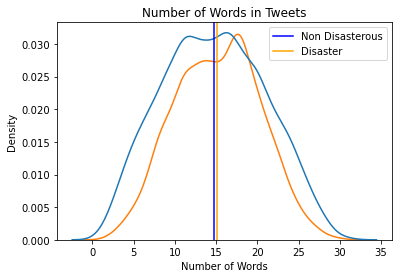

In [46]:
sns.kdeplot(x='num_words', hue='target', data = tweets)
plt.axvline(x=tweets[tweets['target']==0]['num_words'].mean(), color='blue', label='Non Disasterous')
plt.axvline(x=tweets[tweets['target']==1]['num_words'].mean(), color = 'orange', label='Disaster')
plt.title('Number of Words in Tweets')
plt.xlabel('Number of Words')
plt.legend();

The distribution of number of words seem to be bimodal. The two classes, as expected from inspecting the summary information, do have a very similar shape. 

#### 3.7.3 Length of words

In [47]:
#let's explore the difference in the tweets for disaster and non disasters. 
print('Summary of Number of Words in Disaster Tweets:')
print(disaster_tweets.mean_word_length.describe())
print('\n')
print('Summary of Number of Words in Non Disaster Tweets:')
print(nondisaster_tweets.mean_word_length.describe())

Summary of Number of Words in Disaster Tweets:
count    3271.000000
mean        6.469866
std         1.516937
min         3.000000
25%         5.476190
50%         6.352941
75%         7.312500
max        19.333333
Name: mean_word_length, dtype: float64


Summary of Number of Words in Non Disaster Tweets:
count    4342.000000
mean        5.871325
std         1.742150
min         2.250000
25%         4.600000
50%         5.538462
75%         6.818182
max        16.857143
Name: mean_word_length, dtype: float64


The IQR varies only very slightly between the two classes, but the maximum length of the words do vary quite a bit. Let's look the minimums and maximums in a little more detail first. 

In [48]:
tweets[tweets['mean_word_length']<=3]

,text,target,num_chars,num_words,mean_word_length,num_hashtags,mentions,emojis
7,I'm on top of the hill and I can see a fire in the woods...,1,59,15,3.000000,0,0,0
18,My car is so fast,0,17,5,2.600000,0,0,0
659,Yo I got bars and I'm not even a rapper,0,39,10,3.000000,0,0,0
675,?? Yes I do have 2 guns ?? ??,0,29,9,2.333333,0,0,0
724,i hit my foot now my toe is bleeding ??,0,39,10,3.000000,0,0,0
849,Rip ?? Blood !,0,14,4,2.750000,0,0,0
856,We gone get it get it in blood,0,31,8,2.875000,0,0,0
1569,If u faved that I hope you fall off a cliff ??,0,46,12,2.916667,0,0,0
1573,Do me a favor and fall off a cliff,0,34,9,2.888889,0,0,0
1580,I hope you fall off a cliff,0,27,7,3.000000,0,0,0


There are a lot of question marks and exclamation marks here- these are worth removing. We do see these shorter tweets are more common in target class 0, the non disaster tweets, that in class 1. 

In [49]:
tweets[tweets['mean_word_length']>=16]

,text,target,num_chars,num_words,mean_word_length,num_hashtags,mentions,emojis
113,Aftershock https://t.co/xMWODFMtUI,0,34,2,16.500000,0,0,0
131,Aftershock https://t.co/jV8ppKhJY7,0,34,2,16.500000,0,0,0
321,Armageddon https://t.co/uCSUDk3q1d,1,34,2,16.500000,0,0,0
1826,Intact+MH370+Part+Lifts+Odds+Plane+Glided+Not+Crashed+Into+Sea http://t.co/MjTN3qbgOS via @YahooFinance#Hope for answers.,1,121,6,19.333333,0,1,0
3661,@EBROINTHEAM jay....big L....pun....biggie...wrap over...zero question....fatality...flawless victory http://t.co/Y33QcKq7qD,0,124,7,16.857143,0,1,0
3681,@Babybackreeve FATALITY!!!!!!!!!!,0,33,2,16.000000,0,1,0
3883,Flattened https://t.co/9jCIBenckz,0,33,2,16.000000,0,0,0
4234,@TheBlackshag @dannyoneil too toxic...cancer....disease...hazardous waste...noxious...,1,86,5,16.400000,0,2,0
6593,Remembrance http://t.co/ii4EwE1QIr #Hiroshima http://t.co/H3vUsqzyQo,1,69,4,16.250000,1,0,0


When we look at tweets with mean word length greater or equal to 16 we see that a lot of these have urls which are increasing the mean count. THis again suggests we should remove html and url text prior to doing further analysis. 

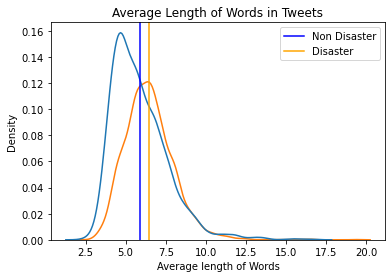

In [50]:
sns.kdeplot(x='mean_word_length', hue='target', data = tweets)
plt.axvline(x=tweets[tweets['target']==0]['mean_word_length'].mean(), color='blue', label='Non Disaster')
plt.axvline(x=tweets[tweets['target']==1]['mean_word_length'].mean(), color = 'orange', label='Disaster')
plt.title('Average Length of Words in Tweets')
plt.xlabel('Average length of Words')
plt.legend()

# comment

#### 3.7.4 Number of Hashtags

In [51]:
print('Summary of Number of Words in Disaster Tweets:')
print(disaster_tweets.num_hashtags.describe())
print('\n')
print('Summary of Number of Words in Non Disaster Tweets:')
print(nondisaster_tweets.num_hashtags.describe())

Summary of Number of Words in Disaster Tweets:
count    3271.000000
mean        0.509019
std         1.196259
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        13.000000
Name: num_hashtags, dtype: float64


Summary of Number of Words in Non Disaster Tweets:
count    4342.000000
mean        0.385767
std         0.999060
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        11.000000
Name: num_hashtags, dtype: float64


In [52]:
tweets[tweets['num_hashtags']>=11]

,text,target,num_chars,num_words,mean_word_length,num_hashtags,mentions,emojis
312,RT @Ophiuchus2613: #Love #TrueLove #romance lith #Voodoo #seduction #Astrology #RTRRT #LOTZ 9-11 #apocalypse #Armageddon #1008plaÛ_,0,133,15,7.866667,11,1,0
318,RT @RTRRTcoach: #Love #TrueLove #romance lith #Voodoo #seduction #Astrology #RTRRT #LOTZ 9-11 #apocalypse #Armageddon #1008planetÛ_,0,133,15,7.866667,11,1,0
4468,No #news of #hostages in #Libya\n\nhttp://t.co/eXil1bKzmP\n\n#India #terrorism #Africa #AP #TS #NRI #News #TRS #TDP #BJP http://t.co/ehomn68oJB,1,139,18,6.666667,13,0,0
4480,No #news of #hostages in #Libya\n\nhttp://t.co/bjjOIfzUhL\n\n#India #terrorism #Africa #AP #TS #NRI #News #TRS #TDP #BJP http://t.co/IywZAlLsN4,1,139,18,6.666667,13,0,0
4483,No #news of #hostages in #Libya\n\nhttp://t.co/k9FBtcCU58\n\n#India #terrorism #Africa #AP #TS #NRI #News #TRS #TDP #BJP http://t.co/XYj0rPsAI2,1,139,18,6.666667,13,0,0
7197,Rare insight into #terror and How to fight it http://t.co/t6OBVWaPhW #Cameroon #USA #Whitehouse #ES #FR #Nigeria #UK #Africa #DE #CA #AU #JP,1,140,22,5.409091,13,0,0


# Comment

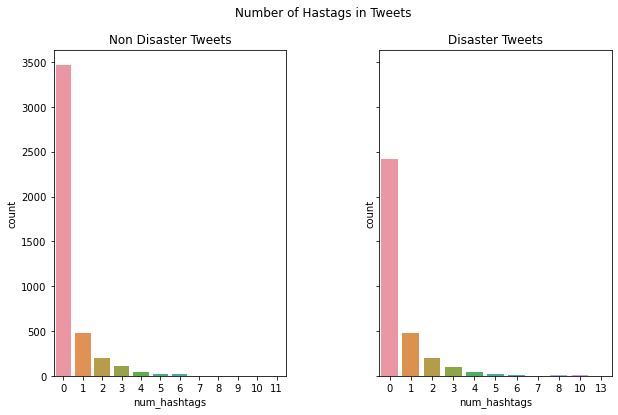

In [53]:
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
fig.suptitle('Number of Hastags in Tweets')
sns.countplot(x=tweets[tweets['target']==0]['num_hashtags'], data=tweets, ax=ax[0])
sns.countplot(x=tweets[tweets['target']==1]['num_hashtags'], data=tweets, ax=ax[1])
ax[0].set_title('Non Disaster Tweets')
ax[1].set_title('Disaster Tweets')
plt.subplots_adjust(wspace=0.4)
plt.show()

Both of the classes have the same trend where majority of the tweets have no hashtags. So we can remove the hashtags and not worry too much about losing valuable information. 

#### 3.7.5 Number of Mentions

In [54]:
print('Summary of Number of Words in Disaster Tweets:')
print(disaster_tweets.mentions.describe())
print('\n')
print('Summary of Number of Words in Non Disaster Tweets:')
print(nondisaster_tweets.mentions.describe())

Summary of Number of Words in Disaster Tweets:
count    3271.000000
mean        0.265668
std         0.612843
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: mentions, dtype: float64


Summary of Number of Words in Non Disaster Tweets:
count    4342.000000
mean        0.413404
std         0.759633
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         8.000000
Name: mentions, dtype: float64


In [55]:
tweets[tweets['num_hashtags']>=5]

,text,target,num_chars,num_words,mean_word_length,num_hashtags,mentions,emojis
12,#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count,1,76,12,5.333333,5,0,0
104,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yNXnvVKCDA | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/weQPesENku,0,138,16,7.687500,6,1,0
106,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0,138,16,7.687500,6,1,0
114,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/M4JDZMGJoW | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/n0uhAsfkBv,0,138,16,7.687500,6,1,0
115,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0,138,16,7.687500,6,1,0
...,...,...,...,...,...,...,...,...
7300,God forbid this is true #California has enough problems with severe #drought &amp; #wild fires. http://t.co/CMsgexM4FC #Nuclear Power #SanOnofre,1,144,19,6.631579,5,0,0
7350,This machine really captured my attention. #helicopter #firefighting #wildfire #oregon #easternoregonÛ_ https://t.co/V6qxnFHRxF,1,128,12,9.750000,5,0,0
7438,Read ~ THE UNHEALED WOUNDS OF AN UNENDING CONFLICT #Kashmir #Pakistan #India http://t.co/sAF9MoSkSN #EndOccupation #EndConflict #FreeKashmir,1,140,16,7.812500,6,0,0
7480,Ranking #artectura #pop2015 #Nå¼36 Florence + The Machine - Ship To Wreck https://t.co/9LE0B19lVF #music #playlist #YouTube,0,124,16,6.750000,6,0,0


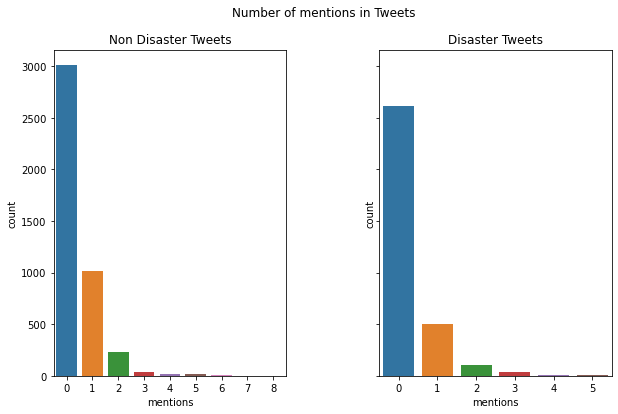

In [56]:
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
fig.suptitle('Number of mentions in Tweets')
sns.countplot(x=tweets[tweets['target']==0]['mentions'], data=tweets, ax=ax[0])
sns.countplot(x=tweets[tweets['target']==1]['mentions'], data=tweets, ax=ax[1])
ax[0].set_title('Non Disaster Tweets')
ax[1].set_title('Disaster Tweets')
plt.subplots_adjust(wspace=0.4)
plt.show()

The trend again follows the same trend as we saw in hashtags- majority of the tweets have no mentions. It's interesting to see that the range of number of mentions is larger than the range for danger tweets. 

#### 4.7.6 Emojis

In [57]:
print('Summary of Number of Words in Disaster Tweets:')
print(disaster_tweets.emojis.describe())
print('\n')
print('Summary of Number of Words in Non Disaster Tweets:')
print(nondisaster_tweets.emojis.describe())

Summary of Number of Words in Disaster Tweets:
count    3271.000000
mean        0.003974
std         0.062926
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: emojis, dtype: float64


Summary of Number of Words in Non Disaster Tweets:
count    4342.000000
mean        0.003685
std         0.060599
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: emojis, dtype: float64


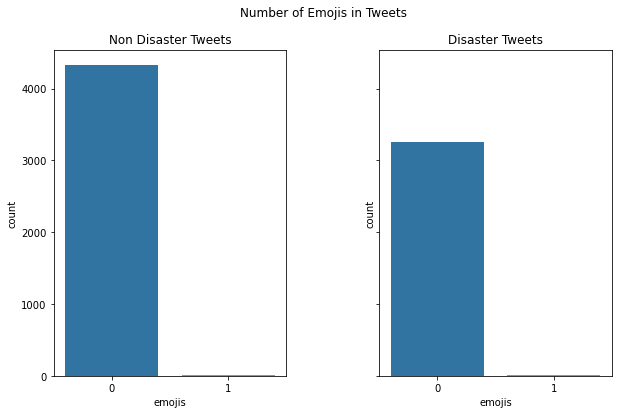

In [58]:
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
fig.suptitle('Number of Emojis in Tweets')
sns.countplot(x=tweets[tweets['target']==0]['emojis'], data=tweets, ax=ax[0])
sns.countplot(x=tweets[tweets['target']==1]['emojis'], data=tweets, ax=ax[1])
ax[0].set_title('Non Disaster Tweets')
ax[1].set_title('Disaster Tweets')
plt.subplots_adjust(wspace=0.4)
plt.show()

#### 4.7.7 Nouns

In [59]:
nlp = spacy.load('en_core_web_sm')
def proper_nouns(text, model=nlp):
    doc = model(text)
    pos = [token.pos_ for token in doc]
    return pos.count('PROPN')
def nouns(text, model=nlp):
    doc = model(text)
    pos = [token.pos_ for token in doc]
    return pos.count('NOUN')
tweets['num_proper_nouns'] = tweets['text'].apply(proper_nouns)
tweets['num_nouns'] = tweets['text'].apply(nouns)

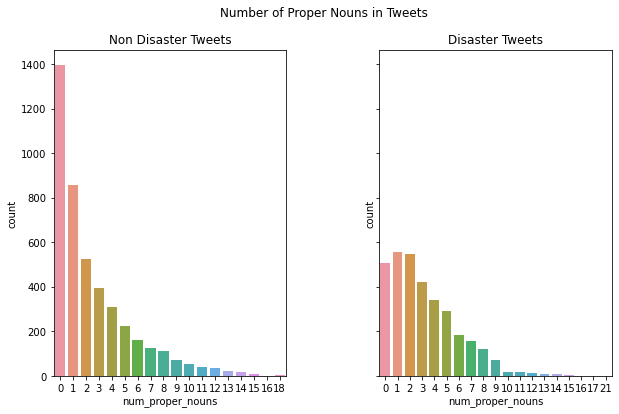

In [60]:
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
fig.suptitle('Number of Proper Nouns in Tweets')
sns.countplot(x=tweets[tweets['target']==0]['num_proper_nouns'], data=tweets, ax=ax[0])
sns.countplot(x=tweets[tweets['target']==1]['num_proper_nouns'], data=tweets, ax=ax[1])
ax[0].set_title('Non Disaster Tweets')
ax[1].set_title('Disaster Tweets')
plt.subplots_adjust(wspace=0.4)
plt.show()

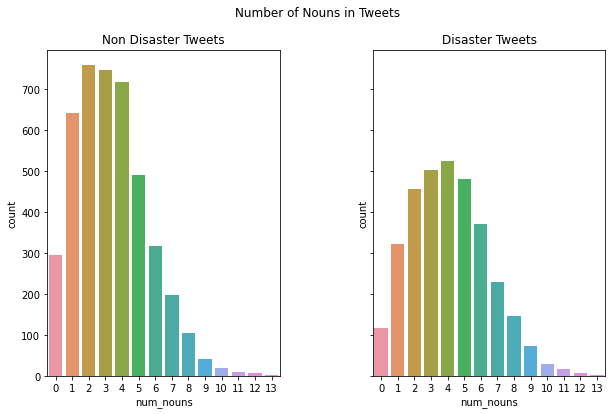

In [61]:
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
fig.suptitle('Number of Nouns in Tweets')
sns.countplot(x=tweets[tweets['target']==0]['num_nouns'], data=tweets, ax=ax[0])
sns.countplot(x=tweets[tweets['target']==1]['num_nouns'], data=tweets, ax=ax[1])
ax[0].set_title('Non Disaster Tweets')
ax[1].set_title('Disaster Tweets')
plt.subplots_adjust(wspace=0.4)
plt.show()

# Comment

<AxesSubplot:>

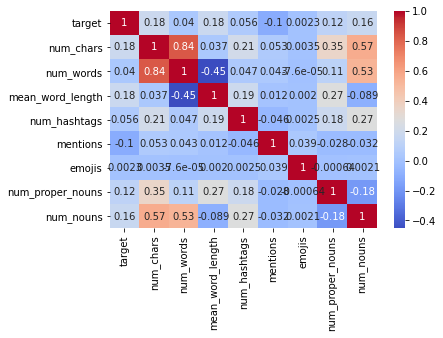

In [62]:
sns.heatmap(data=tweets.corr(), cmap='coolwarm', annot=True)


## 4. Text Preprocessing 

### 4.1 Emojis

In [63]:
def emojis(tweet):
    tweet = emoji.demojize(tweet)
    tweet = tweet.replace(':','')
    cleaned_text = ' '.join(tweet.split())
    return cleaned_text
processed_tweets['text'] = processed_tweets['text'].apply(lambda x: emojis(x))

Now, let's remove the hashtags, mentions, html texts, url texts, and accents as previously discussed. Let's also remove all numbers as they don't really help with sentimental analysis. 

### 4.2 Slang/Colloquial words 

I'm going to use a dictionary of abbreviations used in common colloquialisms: 
https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt

### 4.3 Further cleaning

In [64]:
#let's expand on the common contractions we found earlier. 
def expand_contractions(tweet):
    return contractions.fix(tweet)
processed_tweets['text'] = processed_tweets['text'].apply(lambda x: expand_contractions(x))

#now let's remove the hashtags, mentions, html text, and url 
def remove_hashtag(tweet):
    cleaned_text = re.sub(r'#\w+','',tweet)
    return cleaned_text
def remove_mentions(tweet):
    cleaned_text = re.sub(r'@\w+','',tweet)
    return cleaned_text
def remove_html_text(tweet):
    html_text = re.compile(r'<.*?>|\n|\t')
    cleaned_text = html_text.sub(r'',tweet)
    return cleaned_text
def remove_url_text(tweet):
    url = re.compile(r'https?://\S+|www\.\S+|http://t.co/|http')
    cleaned_text = url.sub(r'',tweet)
    return cleaned_text
#let's also get rid of accents
def remove_accents(tweet):
    cleaned_text = unidecode.unidecode(tweet)
    return cleaned_text
#remove numerical values 
def remove_nums(tweet):
    cleaned_text = re.sub(r'\d+', '', tweet)
    return cleaned_text
#change all tweets to lower case
def lower_case(tweet):
    lower_case = tweet.lower()
    return lower_case

processed_tweets['text'] = processed_tweets['text'].apply(lambda x: remove_hashtag(x))
processed_tweets['text'] = processed_tweets['text'].apply(lambda x: remove_mentions(x))
processed_tweets['text'] = processed_tweets['text'].apply(lambda x: remove_url_text(x))
processed_tweets['text'] = processed_tweets['text'].apply(lambda x: remove_html_text(x))
processed_tweets['text'] = processed_tweets['text'].apply(lambda x: remove_accents(x))
processed_tweets['text'] = processed_tweets['text'].apply(lambda x: remove_punctuation(x))
processed_tweets['text'] = processed_tweets['text'].apply(lambda x: remove_nums(x))
processed_tweets['text'] = processed_tweets['text'].apply(lambda x: lower_case(x))

### 4.3 Stopwords

Prior to removing stopwords let's identiy the most common words in both classes.

In [65]:
disaster_words = Counter(" ".join(processed_tweets[processed_tweets['target']==1]["text"]).split()).most_common(1000)
nondisaster_words = Counter(" ".join(processed_tweets[processed_tweets['target']==0]["text"]).split()).most_common(1000)

Now we can remove these to clean up the tweets a litte more before we do any further analysis

In [66]:
custom_stopwords = np.intersect1d(disaster_words, nondisaster_words)

In [67]:
print('Number of common words in both classes:', len(custom_stopwords))

Number of common words in both classes: 640


In [68]:
def remove_stopwords(tweet):
    cleaned_text = ' '.join([word for word in str(tweet).split() if word not in custom_stopwords])
    return cleaned_text
processed_tweets['text'] = processed_tweets['text'].apply(lambda x: remove_stopwords(x))

In [69]:
processed_tweets.head()

,target,text
0,1,deeds allah forgive
1,1,near la ronge sask canada
2,1,residents asked shelter notified officers shelter orders expected
3,1,receive orders california
4,1,sent ruby pours


In [70]:
#finally, lets get rid of any white space there may have been accidently left behind from the removal processes. 
def remove_extra_w_space(tweet):
    cleaned_text = re.sub(r"\s+"," ",tweet).strip()
    return cleaned_text
processed_tweets['text'] = processed_tweets['text'].apply(lambda x: remove_extra_w_space(x) )

### 4.2 Tokenizer and Lemmetizer

In [71]:
tweet_tokenizer = TweetTokenizer()
processed_tweets['tokens'] = processed_tweets['text'].apply(tweet_tokenizer.tokenize)
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    return [lemmatizer.lemmatize(w) for w in text]
processed_tweets['lemmas'] = processed_tweets.tokens.apply(lemmatize)

### 4.3 Cleaning up dataset

Let's check if after the cleaning process any of the rows have now become empty or not. 

In [72]:
processed_tweets.isna().sum()

target    0
text      0
tokens    0
lemmas    0
dtype: int64

In [73]:
tweets.columns

Index(['text', 'target', 'num_chars', 'num_words', 'mean_word_length',
       'num_hashtags', 'mentions', 'emojis', 'num_proper_nouns', 'num_nouns'],
      dtype='object')

In [74]:
processed_tweets[['num_chars', 'num_words', 'mean_word_length',
       'num_hashtags', 'mentions', 'emojis', 'num_proper_nouns', 'num_nouns']] = tweets[['num_chars', 'num_words', 'mean_word_length',
       'num_hashtags', 'mentions', 'emojis', 'num_proper_nouns', 'num_nouns']]

In [75]:
processed_tweets.head(2)

,target,text,tokens,lemmas,num_chars,num_words,mean_word_length,num_hashtags,mentions,emojis,num_proper_nouns,num_nouns
0,1,deeds allah forgive,"[deeds, allah, forgive]","[deed, allah, forgive]",69,13,4.384615,1,0,0,2,2
1,1,near la ronge sask canada,"[near, la, ronge, sask, canada]","[near, la, ronge, sask, canada]",38,7,4.571429,0,0,0,4,2


Let's shuffle the dataset. 

In [76]:
processed_tweets = shuffle(processed_tweets)

In [77]:
processed_tweets.head(2)

,target,text,tokens,lemmas,num_chars,num_words,mean_word_length,num_hashtags,mentions,emojis,num_proper_nouns,num_nouns
7299,1,footage strong san bernardino county working tcoqcyqhvnha,"[footage, strong, san, bernardino, county, working, tcoqcyqhvnha]","[footage, strong, san, bernardino, county, working, tcoqcyqhvnha]",137,21,5.571429,0,0,0,5,3
810,0,locksmithingart respecting elaboration blight locks lpdkl,"[locksmithingart, respecting, elaboration, blight, locks, lpdkl]","[locksmithingart, respecting, elaboration, blight, lock, lpdkl]",64,7,8.285714,0,0,0,0,4


In [78]:
processed_tweets.to_csv('processed_data.csv')